In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle
from category_encoders import TargetEncoder, OneHotEncoder
import warnings
import pgeocode
import datetime
from math import radians
import joblib
import json
warnings.filterwarnings("ignore")
%matplotlib inline

# 1) Data Formatting

## Open Excel File in DataFrame

In [2]:
df = pd.read_excel('CarData.xlsx')

In [3]:
data = df.copy()

In [4]:
print(len(data.index))

62962


## Remove Incorrect Records

In [5]:
def find_incorrect_records(make, trim):
  if make in trim:
    return False
  return True

In [6]:
for i, row in data.iterrows():
  if find_incorrect_records(row['Make'], row['Trim']):
    data = data.drop(i)

## Remove Duplicates

In [7]:
data = data.drop_duplicates(subset=['VIN'])

In [8]:
data = data.drop('VIN', axis=1)

In [9]:
print(len(data.index))

61379


## Parse Column Information

In [10]:
def parse_year(car_string):
  match = re.search(r'\b(19|20)\d{2}\b', car_string)
  return int(match.group(0)) if match else None

def parse_trim(car_string, make, model):
  if make in car_string:
    trim = car_string.split(make, 1)[1]
    if model in trim:
      trim = trim.split(model, 1)[1]
      trim = trim.replace('for Sale', '')
      return str(trim.strip())
    else:
      return None
  else:
    return None

def parse_zip_code(location):
  if type(location) == str:
    zip = location.split(' ')[-1]
    return str(zip)
  return None

def parse_price(price):
  if type(price) == str:
    num = price.replace('$','')
    num = num.replace(',','')
    return int(num)
  return None

def parse_miles(miles):
  if type(miles) == str:
    mileage = miles.replace(' miles', '')
    mileage = mileage.replace(',','')
    return int(mileage.strip())
  return None

def parse_engine_size(engine):
  if type(engine) == str and '-cylinder' in engine:
    size = engine.replace('-cylinder','')
    return int(size.strip())
  return None

def parse_seats(seats):
  if type(seats) == str and 'seater' in seats:
    seats = seats.replace('seater','')
    return int(seats.strip())
  return None

In [11]:
data['Year'] = data['Year'].apply(parse_year)

data['Trim'] = data.apply(lambda row: parse_trim(row['Trim'], row['Make'], row['Model']), axis=1)

data['Location'] = data['Location'].apply(parse_zip_code)

data['Price'] = data['Price'].apply(parse_price)

data['Mileage'] = data['Mileage'].apply(parse_miles)

data['Engine_Size'] = data['Engine_Size'].apply(parse_engine_size)

data['Seats'] = data['Seats'].apply(parse_seats)

data.loc[data['Fuel_Type'] == 'Electric', 'Engine_Size'] = 0

data.loc[data['Fuel_Type'] == 'Natural Gas', 'Fuel_Type'] = 'Gas'

## Remove Some Null Values

In [12]:
len(data.index)

61379

In [13]:
data.sample(1)

,Make,Model,Year,Trim,Location,Price,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Seats,Drive_Type
49105,Nissan,Maxima,2012,3.5 S,08312,2495.0,223724.0,CVT,Silver,6.0,Gas,22.0,5.0,FWD


In [14]:
data = data.drop(data[data['Trim'].isna()].index)

In [15]:
data = data.drop(data[data['Trim']==''].index)

In [16]:
len(data.index)

59749

In [17]:
data.isna().sum().sum()

np.int64(28568)

## Replace Missing Engine Size

In [18]:
print("Engine Size: ", data['Engine_Size'].unique())

Engine Size:  [ 6.  4.  0. nan  8. 12.  5. 10.  3. 16.]


In [19]:
data['Engine_Size'].isna().sum()

np.int64(758)

In [20]:
def med_engine_size(model, year, trim, data, window=2):
  year_range = (year-window, year+window)
  relevant_data = data[(data['Model'] == model) & (data['Year'].between(year_range[0], year_range[1])) & (data['Trim'] == trim)]
  median_engine_size = relevant_data['Engine_Size'].median()
  return median_engine_size if not pd.isna(median_engine_size) else np.nan

In [21]:
def fill_nan_with_median(row):
  if pd.isna(row['Engine_Size']):
    return med_engine_size(row['Model'], row['Year'], row['Trim'], data)
  return row['Engine_Size']

In [22]:
data['Engine_Size'] = data.apply(fill_nan_with_median, axis=1)

In [23]:
data['Engine_Size'].isna().sum()

np.int64(624)

## Replace Missing Fuel Type

In [24]:
print("Fuel Type: ", data['Fuel_Type'].unique())

Fuel Type:  ['Gas' 'Hybrid' 'Electric' 'Plug-in Hybrid' 'Diesel' 'Flex fuel' nan]


In [25]:
data['Fuel_Type'].isna().sum()

np.int64(538)

In [26]:
def most_common_fuel_type(model, year, data, window=5):
  year_range = (year-window, year+window)
  relevant_data = data[(data['Model'] == model) & (data['Year'].between(year_range[0], year_range[1]))]
  common_fuel_type = relevant_data['Fuel_Type'].mode()
  return common_fuel_type[0] if not common_fuel_type.empty else np.nan

In [27]:
def fill_nan_with_fuel_type(row):
  if pd.isna(row['Fuel_Type']):
    return most_common_fuel_type(row['Model'], row['Year'], data)
  return row['Fuel_Type']

In [28]:
data['Fuel_Type'] = data.apply(fill_nan_with_fuel_type, axis=1)

In [29]:
data['Fuel_Type'].isna().sum()

np.int64(85)

## Replace Missing Transmission

In [30]:
print("Transmission: ", data['Transmission'].unique())

Transmission:  ['Automatic' 'Manual' 'CVT' 'Red' nan]


In [31]:
data = data[data['Transmission'] != 'Red']

In [32]:
data['Transmission'].isna().sum()

np.int64(1418)

In [33]:
def most_common_transmission(model, year, trim, data, window=5):
  year_range = (year-window, year+window)
  relevant_data = data[(data['Model'] == model) & (data['Year'].between(year_range[0], year_range[1])) & (data['Trim'] == trim)]
  common_transmission = relevant_data['Transmission'].mode()
  return common_transmission[0] if not common_transmission.empty else np.nan

In [34]:
def fill_nan_with_transmission(row):
  if pd.isna(row['Transmission']):
    return most_common_transmission(row['Model'], row['Year'], row['Trim'], data)
  return row['Transmission']

In [35]:
data['Transmission'] = data.apply(fill_nan_with_transmission, axis=1)

In [36]:
data['Transmission'].isna().sum()

np.int64(201)

## Replace Missing Gas Mileage

In [37]:
print("Gas Mileage: ", data['Gas_Mileage'].unique())

Gas Mileage:  [ 20.  21.  22.  28.  29.  25.  24.  32.  33.  30.  18.  19.  17.  nan
  23.  15.  27.  26.  87.  77.  13.  14.  16.  12.  34.  83.  31.  68.
  54.  78.  74.  79.  85.  82.  75.  95.  93. 100.  61.  50.  60.  81.
  73.  11.  47.  10.   9.  46.  67.  36.  71.  62.  65.  64. 124. 117.
 113. 111. 118.  96. 109. 120.  91. 105.  90.  76.  69.  86.  56.  89.
  88.  92. 115. 119.  35. 108.  98. 106.  94.  84.  44.  51. 112. 116.
  40.  41.  39. 102.  70.  66. 107.  97. 103.  42.  37.  99.  53.  48.
  43.  45. 110.  38.  52. 114. 121. 127.  55.  58.  59.  80.  49. 101.
 104. 123. 125. 122.  57.  63.]


In [38]:
data['Gas_Mileage'].isna().sum()

np.int64(12800)

In [39]:
def most_common_gas_mileage(model, year, trim, data, window=4):
  year_range = (year-window, year+window)
  relevant_data = data[(data['Model'] == model) & (data['Year'].between(year_range[0], year_range[1])) & (data['Trim'] == trim)]
  common_gas_mileage = relevant_data['Gas_Mileage'].mode()
  return common_gas_mileage[0] if not common_gas_mileage.empty else np.nan

In [40]:
def fill_nan_with_gas_mileage(row):
  if pd.isna(row['Gas_Mileage']):
    return most_common_gas_mileage(row['Model'], row['Year'], row['Trim'], data)
  return row['Gas_Mileage']

In [41]:
data['Gas_Mileage'] = data.apply(fill_nan_with_gas_mileage, axis=1)

In [42]:
data['Gas_Mileage'].isna().sum()

np.int64(8262)

## Replace Missing Drive Type

In [43]:
print("Drive Type: ", data['Drive_Type'].unique())

Drive Type:  ['FWD' 'AWD' 'RWD' 'FOUR_WD' nan '4 seater' 'FOUR_X_FOUR' '7 seater'
 'FOUR_X_TWO' 'JTJBC1BA4D2050855']


In [44]:
data = data.drop(data[data['Drive_Type'] == 'JTJBC1BA4D2050855'].index)
data = data.drop(data[data['Drive_Type'] == '4 seater'].index)
data = data.drop(data[data['Drive_Type'] == '7 seater'].index)
replacements = {
    'FOUR_WD': 'AWD',
    'FOUR_X_FOUR': 'AWD',
    'FOUR_X_TWO': 'RWD'
}

data['Drive_Type'] = data['Drive_Type'].replace(replacements)

In [45]:
data['Drive_Type'].isna().sum()

np.int64(704)

In [46]:
def most_common_drive_type(model, year, trim, data, window=4):
  year_range = (year-window, year+window)
  relevant_data = data[(data['Model'] == model) & (data['Year'].between(year_range[0], year_range[1])) & (data['Trim'] == trim)]
  common_drive_type = relevant_data['Drive_Type'].mode()
  return common_drive_type[0] if not common_drive_type.empty else np.nan

In [47]:
def fill_nan_with_drive_type(row):
  if pd.isna(row['Drive_Type']):
    return most_common_drive_type(row['Model'], row['Year'], row['Trim'], data)
  return row['Drive_Type']

In [48]:
data['Drive_Type'] = data.apply(fill_nan_with_drive_type, axis=1)

In [49]:
data['Drive_Type'].isna().sum()

np.int64(533)

## Replace Missing Mileage

In [50]:
data['Mileage'].isna().sum()

np.int64(2753)

In [51]:
def average_mileage(model, year, data, window=1):
    year_range = (year-window, year+window)
    relevant_data = data[(data['Model'] == model) & (data['Year'].between(year_range[0], year_range[1]))]
    avg_mlg = relevant_data['Mileage'].mean()
    if pd.isna(avg_mlg):
        return np.nan
    noise = avg_mlg*0.05
    return np.random.normal(avg_mlg, noise)

In [52]:
def fill_nan_with_miles(row):
  if pd.isna(row['Mileage']):
    return average_mileage(row['Model'], row['Year'], data)
  return row['Mileage']

In [53]:
data['Mileage'] = data.apply(fill_nan_with_miles, axis=1)

In [54]:
data['Mileage'].isna().sum()

np.int64(56)

## Fixing Incorrect Colors

In [55]:
def is_number(s):
    s = str(s)
    return not s.isdigit()

In [56]:
mask = data['Color'].apply(is_number)
data = data[mask]

In [57]:
data = data[data['Color']!='--']

In [58]:
def remove_square_brackets(s):
    s = str(s)
    return re.sub(r'\[.*?\]', '', s).strip()

In [59]:
data['Color'] = data['Color'].apply(remove_square_brackets)

## Removing Final Null/Incorrect Values

In [60]:
data.sample()

,Make,Model,Year,Trim,Location,Price,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Seats,Drive_Type
32494,Jeep,Wagoneer L,2024,Series III,27948,85432.0,10.0,Automatic,White,6.0,Gas,19.0,7.0,AWD


In [61]:
print("Price: ", data['Price'].isna().sum())
print("Mileage: ", data['Mileage'].isna().sum())
print("Transmission: ", data['Transmission'].isna().sum())
print("Color: ", data['Color'].isna().sum())
print("Engine_Size: ", data['Engine_Size'].isna().sum())
print("Fuel_Type: ", data['Fuel_Type'].isna().sum())
print("Gas Mileage: ", data['Gas_Mileage'].isna().sum())
print("Drive_Type: ", data['Drive_Type'].isna().sum())

Price:  6421
Mileage:  56
Transmission:  201
Color:  0
Engine_Size:  624
Fuel_Type:  85
Gas Mileage:  8244
Drive_Type:  532


In [62]:
data.isna().sum().sum()

np.int64(16498)

In [63]:
data = data.dropna()

In [64]:
len(data.index)

45897

In [65]:
data.isna().sum().sum()

np.int64(0)

In [66]:
# removing seats drops MAE
data = data.drop(columns=['Seats'])

In [67]:
data.sample()

,Make,Model,Year,Trim,Location,Price,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type
18037,Ford,Crown Victoria,2011,Police Interceptor,08322,7995.0,137298.0,Automatic,White,8.0,Flex fuel,14.0,RWD


## Add Coordinates From Zip Code

In [68]:
nomi = pgeocode.Nominatim('us')


latitudes = []
longitudes = []

for zip_code in data['Location']:
    location = nomi.query_postal_code(zip_code)
    latitudes.append(location.latitude if location is not None else None)
    longitudes.append(location.longitude if location is not None else None)

data['Latitude'] = latitudes
data['Longitude'] = longitudes
data['Latitude'] = data['Latitude'].apply(radians)
data['Longitude'] = data['Longitude'].apply(radians)


In [69]:
data = data.drop(columns=['Location'])

## Replace Year Column

In [70]:
current_year = datetime.datetime.now().year
data['Age'] = current_year - data['Year'].astype(int)
data = data.drop(columns='Year')

In [71]:
data.sample(5)

,Make,Model,Trim,Price,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude,Age
60556,Volkswagen,ID.4,Pro S Plus,57651.0,10.0,Automatic,Deep Black Pearl,0.0,Electric,99.0,AWD,0.708557,-1.292884,1
53761,Saturn,Sky,Red Line,6500.0,102865.0,Automatic,Blue,4.0,Gas,21.0,RWD,0.588440,-2.059623,15
3530,Audi,SQ5,3.0T quattro Premium Plus,35990.0,47198.0,Automatic,Ibis White,6.0,Gas,20.0,AWD,0.705830,-1.315118,3
7693,Buick,Riviera,Base,10500.0,56954.0,Automatic,White,8.0,Gas,17.0,RWD,0.726162,-1.906423,39
30546,Jaguar,F-TYPE,R,34999.0,101528.0,Automatic,White,8.0,Gas,18.0,AWD,0.700373,-1.310056,8


In [72]:
data = data.dropna()

In [73]:
len(data.index)

45853

## Format Dataframe

In [74]:
price = data.pop('Price')
data.insert(13, 'Price', price)

In [75]:
age = data.pop('Age')
data.insert(2, 'Age', age)

In [76]:
data.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude,Price
4852,BMW,7 Series,10,750Li xDrive,88084.0,Automatic,Black,8.0,Gas,19.0,AWD,0.698868,-1.309423,16399.0


# 2) Exploratory Data Analysis

In [ ]:
# Find the total number of cars per manufacturer in the dataset
plt.figure(figsize=(20, 15))
sns.countplot(y=data['Make'])
plt.title("Manufacturer Distribution")
plt.show()

In [ ]:
# Find the number of cars made in each year in the dataset
plt.figure(figsize=(20, 15))
sns.countplot(y=data.Year, palette='viridis')
plt.title("Year Distribution")
plt.show()

In [ ]:
# Number of cars per transmission type
plt.figure(figsize=(20, 15))
sns.countplot(x=data.Transmission, palette='Paired')
plt.title("Transmission Distribution")
plt.show()

In [ ]:
# unique elements in data
data.nunique()

In [ ]:
# fuel type distribution
plt.figure(figsize=(20, 15))
sns.countplot(y=data.Fuel_Type.sort_values(ascending=False), palette='Dark2')


In [ ]:
# Group rows by make
data.groupby('Make')[['Engine_Size','Gas_Mileage', 'Price']].agg(['min','max','mean','median'])

In [ ]:
# average price by year
plt.figure(figsize=(20, 10))
data.groupby('Year')['Price'].mean().plot(kind='bar',color='g')
plt.title('Average Price by Year')
plt.show()

In [ ]:
plt.figure(figsize = (10, 10))
data.groupby('Transmission')['Price'].mean().plot(kind = 'bar', color = 'y')
plt.title("Average Price by Transmission", fontsize = 20)
plt.show()

In [ ]:
plt.figure(figsize = (20, 15))
data.groupby(['Make'])['Price'].mean().sort_values(ascending = False).plot(kind = 'bar', fontsize = 15, color = 'black')
plt.title("Average Price per Manufacturer", fontsize = 20)
plt.show()

In [ ]:
# Group by Drive Type
plt.figure(figsize = (20, 15))
data.groupby(['Drive_Type'])['Price'].mean().sort_values(ascending = False).plot(kind = 'bar', fontsize = 15, color = 'orange')

In [ ]:
sns.scatterplot(x='Engine_Size',y='Gas_Mileage', data=data, color='r')
plt.show()

In [ ]:
# Boxplot of MPG
sns.boxplot(x='Gas_Mileage', data=data,color='r')

In [ ]:
sns.scatterplot(x='Fuel_Type',y='Gas_Mileage', data=data, color='r')
plt.show()

In [ ]:
plt.figure(figsize = (20, 15))
numeric_columns = ['Age', 'Mileage', 'Engine_Size', 'Seats', 'Price']
heatmap_data = data[numeric_columns].corr()
sns.heatmap(heatmap_data, annot=True, cmap='BuPu')

In [ ]:
# Gas Mileage by Year
plt.figure(figsize = (20, 15))
data.groupby('Year')['Gas_Mileage'].mean().plot(kind = 'bar', color = 'g')
plt.title("Gas Mileage by Year", fontsize = 20)
plt.show()

In [ ]:
# Mileage by Year
plt.figure(figsize = (20, 15))
data.groupby('Year')['Mileage'].mean().plot(kind = 'bar', color = 'g')
plt.title("Mileage by Year", fontsize = 20)
plt.show()

In [ ]:
data.info()

# 3) Data Manipulation

In [116]:
print(len(data.index))

45853


In [117]:
frame = data.copy()

In [118]:
frame.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude,Price
3035,Audi,RS Q8,0,4.0T quattro,10.0,Automatic,Glacier White Metallic,8.0,Gas,15.0,AWD,0.711937,-1.29265,135880.0


## Split the Data

In [119]:
shuffled_data = shuffle(frame, random_state=1)
X = shuffled_data.drop('Price', axis=1)
y = shuffled_data['Price']

In [120]:
# Training and Test Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [121]:
print("The size of the input train data is: {}".format(X_train.shape))
print("The size of the output train data is: {}".format(y_train.shape))
print("The size of the input test data is: {}".format(X_test.shape))
print("The size of the output test data is: {}".format(y_test.shape))

The size of the input train data is: (36682, 13)
The size of the output train data is: (36682,)
The size of the input test data is: (9171, 13)
The size of the output test data is: (9171,)


In [122]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude
26707,Hyundai,Ioniq 5,0,SEL,5.0,Automatic,Digital Teal,0.0,Electric,99.0,AWD,0.704884,-1.301244


## Encode Make

In [123]:
make_encoder = TargetEncoder(cols='Make')

In [124]:
make_encoder.fit(X_train['Make'], y_train.to_frame()['Price'])

TargetEncoder(cols=['Make'])

In [125]:
X_train['Make'] = make_encoder.transform(X_train['Make'])

In [126]:
X_test['Make'] = make_encoder.transform(X_test['Make'])

In [127]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude
43598,45350.320675,300-Class,33,300 SE,72052.0,Automatic,Blue,6.0,Gas,16.0,RWD,0.697629,-1.503156


## Encode Model

In [128]:
model_encoder = TargetEncoder(cols='Model')
model_encoder.fit(X_train['Model'], y_train.to_frame()['Price'])
X_train['Model'] = model_encoder.transform(X_train['Model'])
X_test['Model'] = model_encoder.transform(X_test['Model'])

In [129]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude
34687,25271.111593,11335.658368,16,EX,81787.0,Automatic,Silver,4.0,Gas,27.0,FWD,0.723175,-1.443497


## Encode Trim

In [130]:
trim_encoder = TargetEncoder(cols='Trim')
trim_encoder.fit(X_train['Trim'], y_train.to_frame()['Price'])
X_train['Trim'] = trim_encoder.transform(X_train['Trim'])
X_test['Trim'] = trim_encoder.transform(X_test['Trim'])

In [131]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude
58838,27129.020114,54208.062712,0,45904.49691,16.0,Automatic,Magnetic Gray Metallic,6.0,Hybrid,20.0,AWD,0.713552,-1.295286


## Encode Color

In [132]:
color_encoder = TargetEncoder(cols='Color')
color_encoder.fit(X_train['Color'], y_train.to_frame()['Price'])
X_train['Color'] = color_encoder.transform(X_train['Color'])
X_test['Color'] = color_encoder.transform(X_test['Color'])

In [133]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude
5378,52518.833449,91270.412376,-1,90754.991911,7.0,Automatic,60675.194927,0.0,Electric,83.0,AWD,0.702352,-1.303695


## One Hot Encoding

In [134]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Transmission,Color,Engine_Size,Fuel_Type,Gas_Mileage,Drive_Type,Latitude,Longitude
28072,22983.941449,44927.170695,2,26755.050808,53134.0,Automatic,31483.382859,4.0,Plug-in Hybrid,80.0,AWD,0.715564,-1.29898


In [135]:
encoder = OneHotEncoder()
encoder.fit(X_train[['Transmission', 'Fuel_Type', 'Drive_Type']])
one_hot_encoded_output_train = encoder.transform(X_train[['Transmission', 'Fuel_Type', 'Drive_Type']])
one_hot_encoded_output_test = encoder.transform(X_test[['Transmission', 'Fuel_Type', 'Drive_Type']])

In [136]:
X_train = pd.concat([X_train, one_hot_encoded_output_train], axis=1)
X_test = pd.concat([X_test, one_hot_encoded_output_test], axis=1)

In [137]:
X_train = X_train.drop(['Transmission', 'Fuel_Type', 'Drive_Type'],axis=1)
X_test = X_test.drop(['Transmission', 'Fuel_Type', 'Drive_Type'],axis=1)

In [138]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Color,Engine_Size,Gas_Mileage,Latitude,Longitude,...,Transmission_3,Fuel_Type_1,Fuel_Type_2,Fuel_Type_3,Fuel_Type_4,Fuel_Type_5,Fuel_Type_6,Drive_Type_1,Drive_Type_2,Drive_Type_3
42029,20055.201946,35400.536716,0,35747.953626,8804.0,35768.256166,4.0,25.0,0.695521,-1.308379,...,0,1,0,0,0,0,0,0,1,0


In [139]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36682 entries, 60695 to 62221
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Make            36682 non-null  float64
 1   Model           36682 non-null  float64
 2   Age             36682 non-null  int64  
 3   Trim            36682 non-null  float64
 4   Mileage         36682 non-null  float64
 5   Color           36682 non-null  float64
 6   Engine_Size     36682 non-null  float64
 7   Gas_Mileage     36682 non-null  float64
 8   Latitude        36682 non-null  float64
 9   Longitude       36682 non-null  float64
 10  Transmission_1  36682 non-null  int64  
 11  Transmission_2  36682 non-null  int64  
 12  Transmission_3  36682 non-null  int64  
 13  Fuel_Type_1     36682 non-null  int64  
 14  Fuel_Type_2     36682 non-null  int64  
 15  Fuel_Type_3     36682 non-null  int64  
 16  Fuel_Type_4     36682 non-null  int64  
 17  Fuel_Type_5     36682 non-null  

## Standardization/Normalization

In [140]:
X_train.sample()

,Make,Model,Age,Trim,Mileage,Color,Engine_Size,Gas_Mileage,Latitude,Longitude,...,Transmission_3,Fuel_Type_1,Fuel_Type_2,Fuel_Type_3,Fuel_Type_4,Fuel_Type_5,Fuel_Type_6,Drive_Type_1,Drive_Type_2,Drive_Type_3
60025,20626.70388,12699.655081,3,32916.897404,53890.0,31931.881683,4.0,32.0,0.698282,-1.305325,...,0,1,0,0,0,0,0,1,0,0


In [141]:
cols_to_scale = ['Age', 'Mileage', 'Engine_Size', 'Gas_Mileage', 'Latitude', 'Longitude']

In [142]:
# scaler = StandardScaler()
# X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
# X_test[cols_to_scale] = scaler.fit_transform(X_test[cols_to_scale])

In [143]:
X_train.shape

(36682, 22)

# 4) Machine Learning Analysis

In [161]:
mse = []
mae = []

## K-Neighbors Regressor

In [162]:
knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted Price'])
results = pd.concat([y_pred, y_test.to_frame().reset_index(drop=True)], axis=1, ignore_index=False)
mse.append(int(mean_squared_error(y_pred, y_test)))
mae.append(int(mean_absolute_error(y_pred, y_test)))

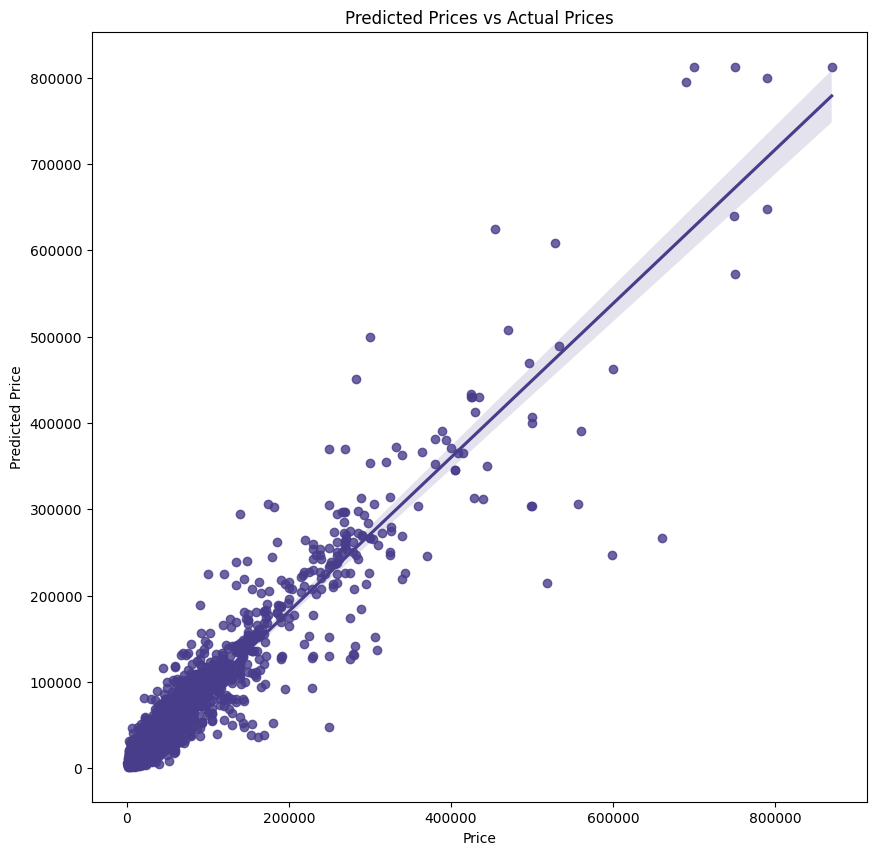

In [163]:
plt.figure(figsize=(10,10))
sns.regplot(data=results, y='Predicted Price', x='Price', color='darkslateblue', marker='o')
plt.title('Predicted Prices vs Actual Prices')
plt.show()

## PLS Regression

In [164]:
pls = PLSRegression(n_components=10)
pls.fit(X_train, y_train)
y_pred = pls.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted Price'])
results = pd.concat([y_pred, y_test.to_frame().reset_index(drop=True)], axis=1, ignore_index=False)
mse.append(int(mean_squared_error(y_pred, y_test)))
mae.append(int(mean_absolute_error(y_pred, y_test)))

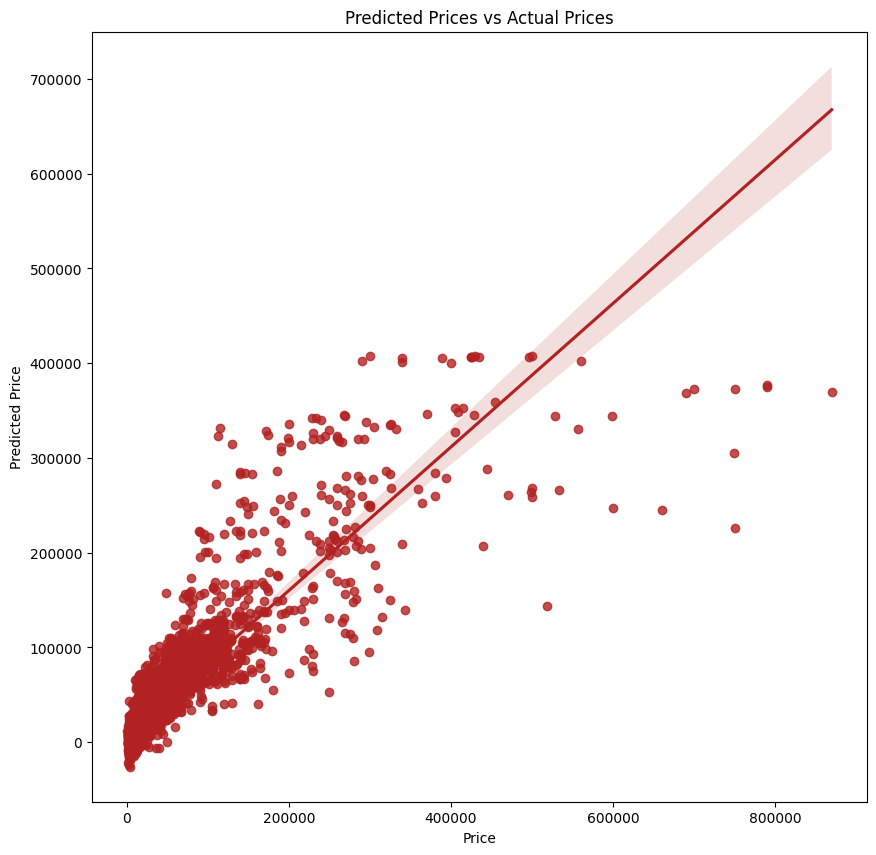

In [165]:
plt.figure(figsize=(10,10))
sns.regplot(data=results, y='Predicted Price', x='Price', color='firebrick', marker='o')
plt.title('Predicted Prices vs Actual Prices')
plt.show()

## Decision Tree Regressor

In [166]:
dt = DecisionTreeRegressor(splitter='random')
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted Price'])
results = pd.concat([y_pred, y_test.to_frame().reset_index(drop=True)], axis=1, ignore_index=False)
mse.append(int(mean_squared_error(y_pred, y_test)))
mae.append(int(mean_absolute_error(y_pred, y_test)))

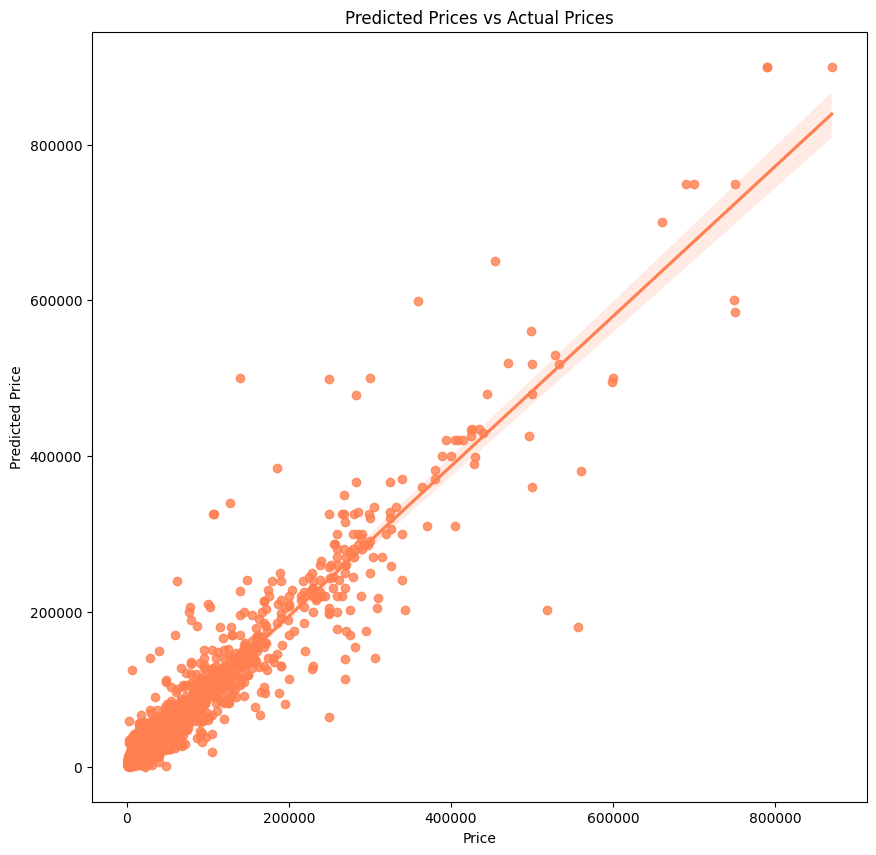

In [167]:
plt.figure(figsize=(10,10))
sns.regplot(data=results, y='Predicted Price', x='Price', color='coral', marker='o')
plt.title('Predicted Prices vs Actual Prices')
plt.show()

## Random Forest Regressor

In [168]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted Price'])
results = pd.concat([y_pred, y_test.to_frame().reset_index(drop=True)], axis=1, ignore_index=False)
mse.append(int(mean_squared_error(y_pred, y_test)))
mae.append(int(mean_absolute_error(y_pred, y_test)))

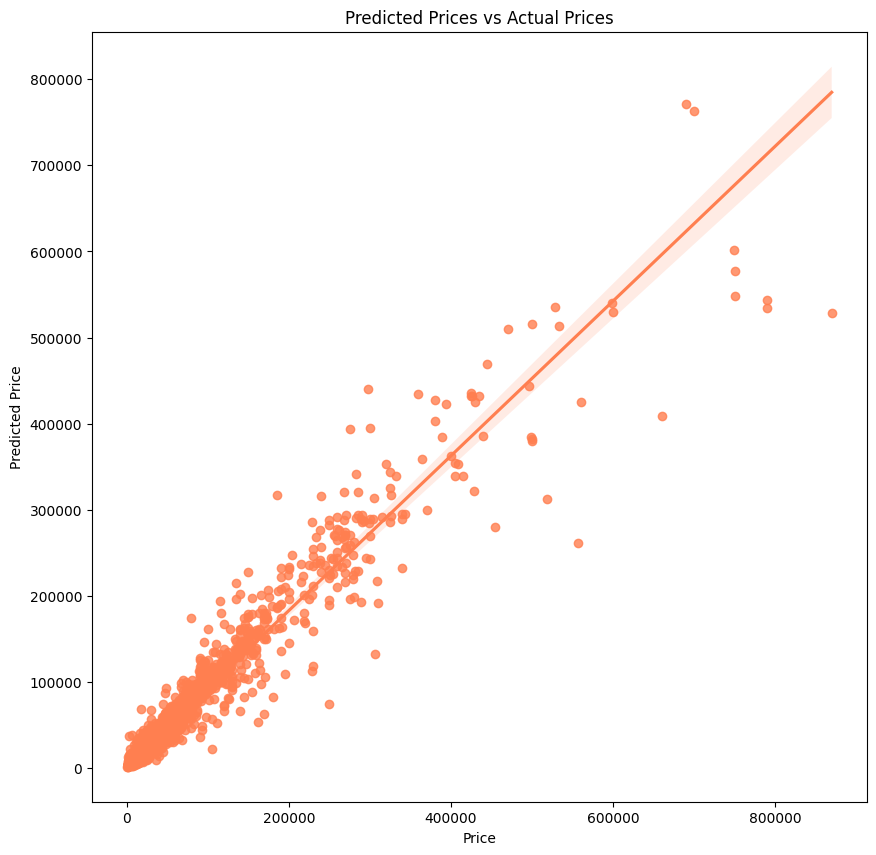

In [169]:
plt.figure(figsize=(10,10))
sns.regplot(data=results, y='Predicted Price', x='Price', color='coral', marker='o')
plt.title('Predicted Prices vs Actual Prices')
plt.show()

## Gradient Boosting Regressor

In [170]:
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted Price'])
results = pd.concat([y_pred, y_test.to_frame().reset_index(drop=True)], axis=1, ignore_index=False)
mse.append(int(mean_squared_error(y_pred, y_test)))
mae.append(int(mean_absolute_error(y_pred, y_test)))

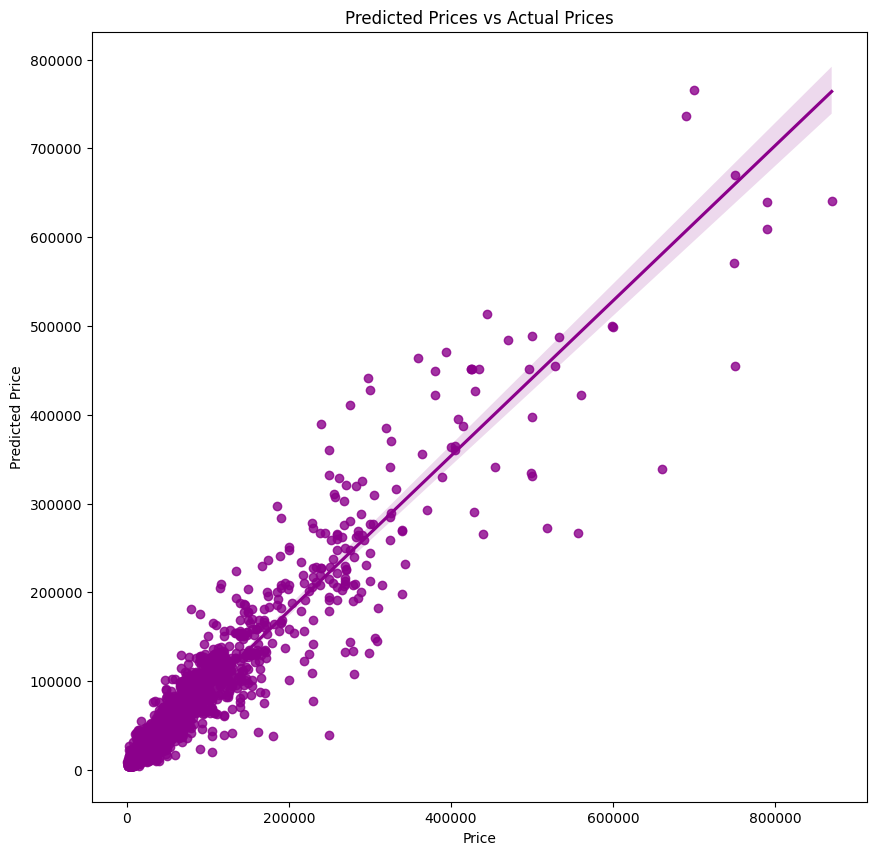

In [171]:
plt.figure(figsize=(10,10))
sns.regplot(data=results, y='Predicted Price', x='Price', color='darkmagenta', marker='o')
plt.title('Predicted Prices vs Actual Prices')
plt.show()

## MLP Regressor

In [172]:
mlp = MLPRegressor(hidden_layer_sizes=50, alpha=0.001, solver='lbfgs', learning_rate='adaptive')
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['Predicted Price'])
results = pd.concat([y_pred, y_test.to_frame().reset_index(drop=True)], axis=1, ignore_index=False)
mse.append(int(mean_squared_error(y_pred, y_test)))
mae.append(int(mean_absolute_error(y_pred, y_test)))

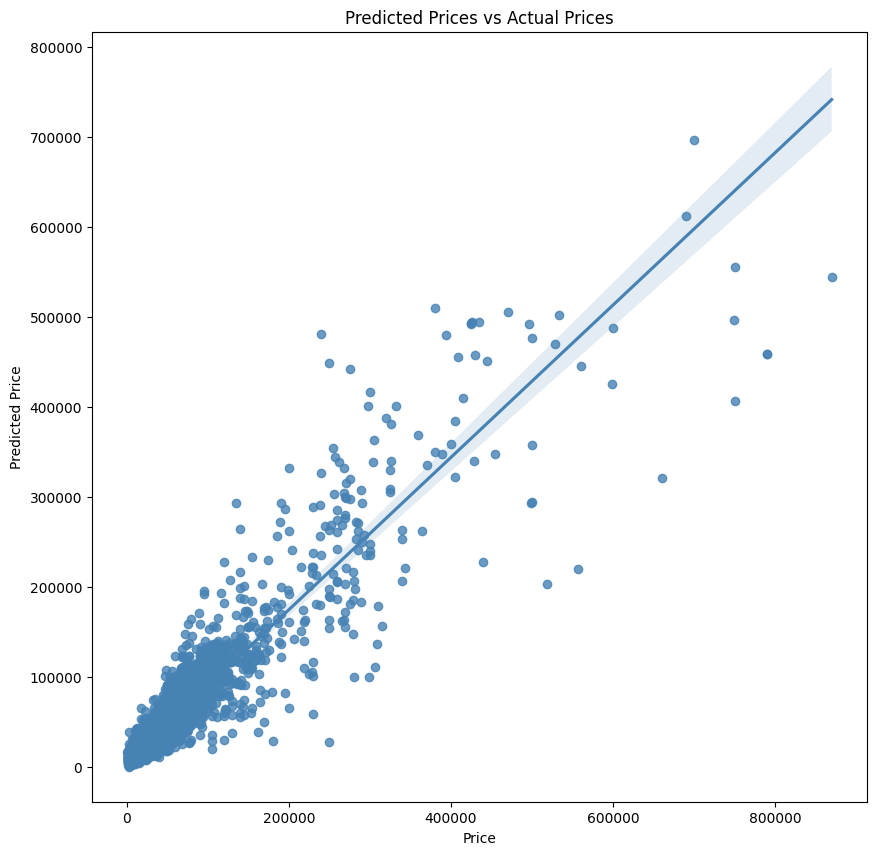

In [173]:
plt.figure(figsize=(10,10))
sns.regplot(data=results, y='Predicted Price', x='Price', color='steelblue', marker='o')
plt.title('Predicted Prices vs Actual Prices')
plt.show()

## Dataframe of Machine Learning Models

In [174]:
models = {'Models': ['K Nearest Regressor', 'PLS Regression', 'Decision Tree Regressor', 'Random Forest Regressor', 'Gradient Boosting Regressor', 'MLP Regressor'], 'Mean Absolute Error': mae, 'Mean Squared Error': mse}
model_dataframe = pd.DataFrame(models)

In [175]:
model_dataframe

,Models,Mean Absolute Error,Mean Squared Error
0,K Nearest Regressor,6123,235971966
1,PLS Regression,10964,608383110
2,Decision Tree Regressor,5020,218839914
3,Random Forest Regressor,3826,147821428
4,Gradient Boosting Regressor,6325,229193981
5,MLP Regressor,8162,357005338


## Barplot of Machine Learning Models

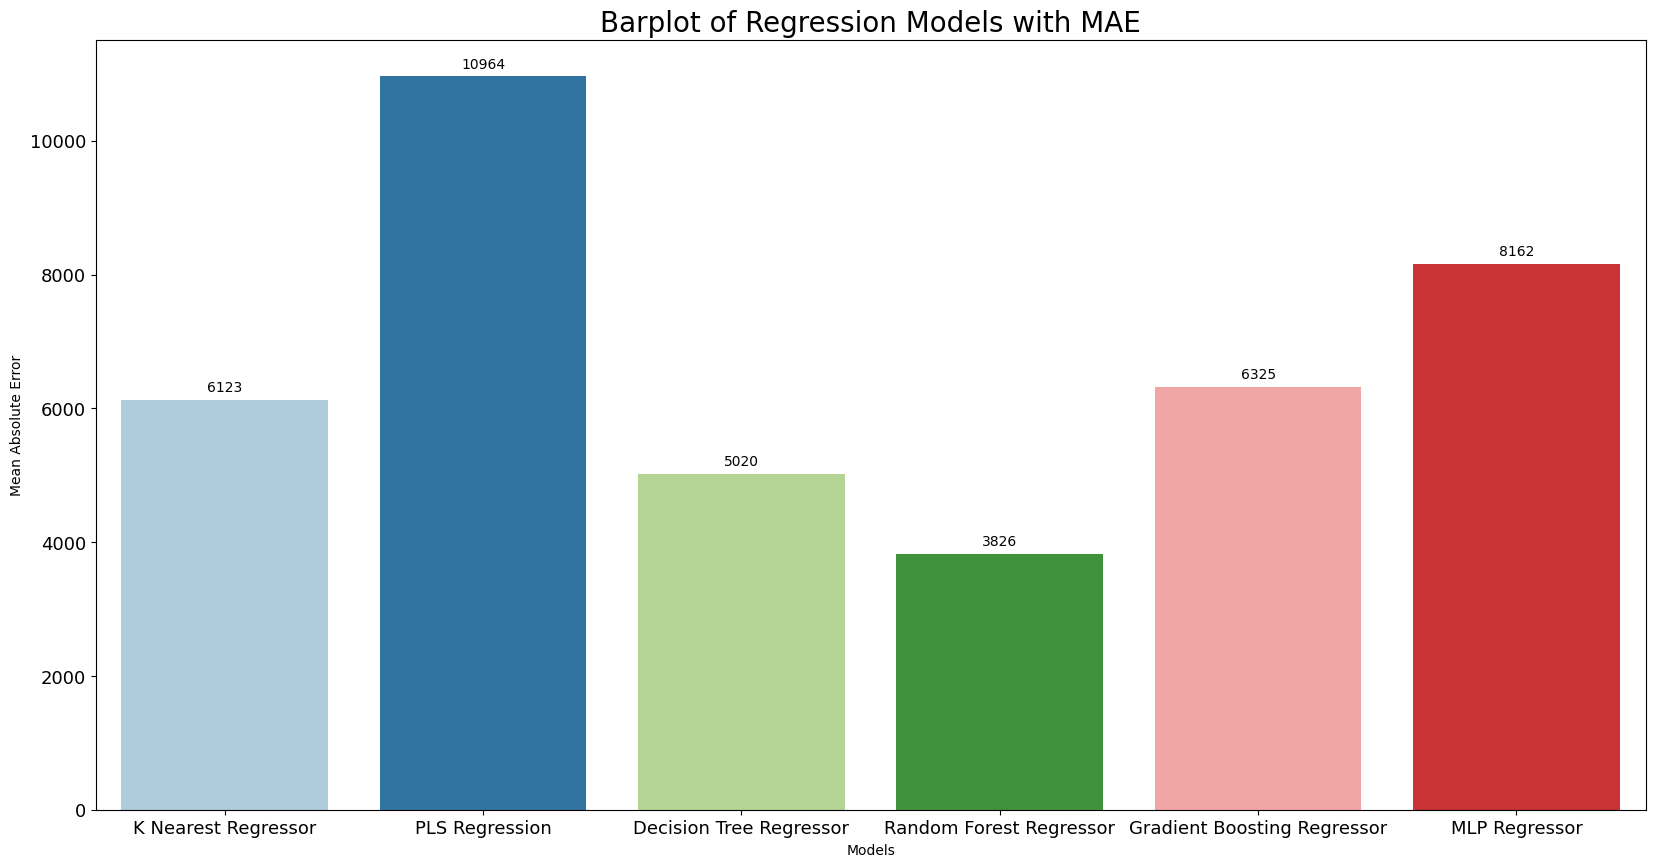

In [176]:
plt.figure(figsize=(20,10))
splot = sns.barplot(data=model_dataframe, x='Models', y='Mean Absolute Error', palette='Paired')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title("Barplot of Regression Models with MAE", fontsize = 20)
plt.show()

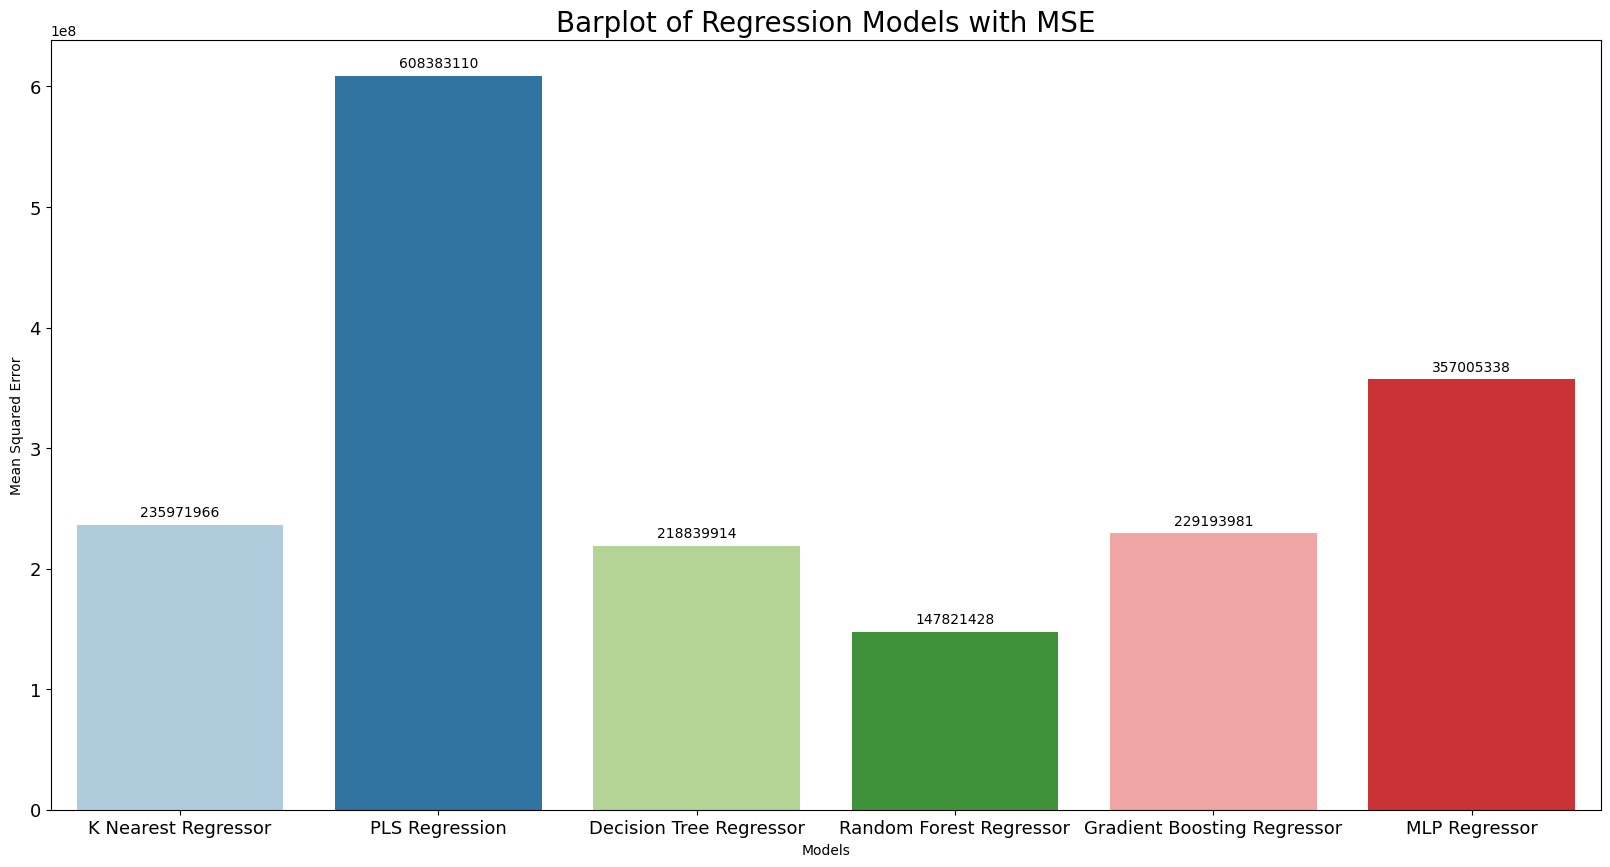

In [177]:
plt.figure(figsize=(20,10))
splot = sns.barplot(data=model_dataframe, x='Models', y='Mean Squared Error', palette='Paired')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title("Barplot of Regression Models with MSE", fontsize = 20)
plt.show()

# 4b) Data Manipulation + Machine Learning w/k-Fold

## Data Manipulation

In [92]:
frame = data.copy()

In [93]:
shuffled_data = shuffle(frame, random_state=1)
X = shuffled_data.drop('Price', axis=1)
y = shuffled_data['Price']

In [94]:
kf = KFold(n_splits=5, shuffle=True,random_state=1)

In [95]:
target_encoder = TargetEncoder()
one_hot_encoder = OneHotEncoder()

In [96]:
target_encoding_features = ['Make', 'Model', 'Trim', 'Color']
one_hot_encoding_features = ['Transmission', 'Fuel_Type', 'Drive_Type']

## Machine Learning

In [97]:
mse = []
mae = []

In [98]:
def train_evaluate(model,X_train,y_train,X_test,mse,mae):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse.append(int(mean_squared_error(y_pred, y_test)))
    mae.append(int(mean_absolute_error(y_pred, y_test)))

In [99]:
model_dict = {
    'knn' : KNeighborsRegressor(),
    'pls' : PLSRegression(),
    'dt' : DecisionTreeRegressor(),
    'rf' : RandomForestRegressor(),
    'gb' : GradientBoostingRegressor(),
    'mlp' : MLPRegressor(hidden_layer_sizes=50, alpha=0.001, solver='lbfgs', learning_rate='adaptive')
}

In [100]:
results = {model_name: {'mae': [], 'mse': []} for model_name in model_dict.keys()}

In [109]:
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train[target_encoding_features] = target_encoder.fit_transform(X_train[target_encoding_features], y_train)
    X_test[target_encoding_features] = target_encoder.transform(X_test[target_encoding_features])

    one_hot_encoded_output_train = one_hot_encoder.fit_transform(X_train[one_hot_encoding_features])
    one_hot_encoded_output_test = one_hot_encoder.transform(X_test[one_hot_encoding_features])
    X_train = pd.concat([X_train, one_hot_encoded_output_train], axis=1)
    X_test = pd.concat([X_test, one_hot_encoded_output_test], axis=1)  
    X_train = X_train.drop(['Transmission', 'Fuel_Type', 'Drive_Type'],axis=1)
    X_test = X_test.drop(['Transmission', 'Fuel_Type', 'Drive_Type'],axis=1)
    
    for model_name, metrics in results.items():
        model = model_dict[model_name]
        train_evaluate(model,X_train,y_train,X_test,results[model_name]['mse'], results[model_name]['mae'])

In [ ]:
models = {'Models': ['K Nearest Regressor', 'PLS Regression', 'Decision Tree Regressor', 'Random Forest Regressor', 'Gradient Boosting Regressor', 'MLP Regressor'], 'Mean Absolute Error': mae, 'Mean Squared Error': mse}
model_dataframe = pd.DataFrame(models)

In [111]:
results_dataframe = pd.DataFrame(results)

In [112]:
results_dataframe

,knn,pls,dt,rf,gb,mlp
mae,"[6070, 6316, 6161, 6329, 6307]","[12991, 12962, 13068, 13142, 13042]","[5204, 4915, 5447, 5117, 5192]","[3838, 3675, 3855, 3803, 3791]","[6321, 6133, 6131, 6267, 6242]","[8150, 8205, 8103, 8083, 8198]"
mse,"[223709936, 250516046, 478041180, 323435680, 2...","[666668378, 658226142, 909632865, 723332818, 7...","[245670478, 175024747, 496379785, 335062693, 2...","[154634841, 99596198, 344061872, 176783151, 14...","[228820620, 178189448, 405983210, 231626270, 2...","[354318944, 316416491, 558456392, 362189542, 3..."


# 5) Predict 

Best Model: 
- Random Forest Regressor: 3598 MAE; 99988885 MSE
- target encoding on make model trim color
- onehot encoding on transmission fuel_type drive_type
- no scaling on Mileage, Engine_Size, Gas_Mileage, Latitude, Longitude
- coordinates in degrees

In [ ]:
new_car = pd.DataFrame({
    'Make':['Audi'],
    'Model':['A8'],
    'Age':['2023'],
    'Trim':['quattro 55 TFSI'],
    'Mileage':7800,
    'Color':['Vesuvius Gray Metallic'],
    'Engine_Size':6,
    'Gas_Mileage':22,
    'Location':['08550'],
    'Transmission':['Automatic'],
    'Fuel_Type':['Gas'],
    'Drive_Type':['AWD'],
})

# replace year with age
current_year = datetime.datetime.now().year
new_car['Age'] = current_year - new_car['Age'].astype(int)

# get coordinates from zip code
nomi = pgeocode.Nominatim('us')
location = nomi.query_postal_code(new_car['Location'][0])
new_car['Latitude'] = location.latitude 
new_car['Longitude'] = location.longitude 
new_car = new_car.drop(columns=['Location'])

# target encoding
new_car['Make'] = make_encoder.transform(new_car['Make'])
new_car['Model'] = model_encoder.transform(new_car['Model'])
new_car['Trim'] = trim_encoder.transform(new_car['Trim'])
new_car['Color'] = color_encoder.transform(new_car['Color'])

# one hot encoding
categorical_features = new_car[['Transmission', 'Fuel_Type', 'Drive_Type']]
one_hot_encoded_new_car = encoder.transform(categorical_features)

one_hot_encoded_new_car_df = pd.DataFrame(one_hot_encoded_new_car, columns=encoder.get_feature_names_out())
new_car = pd.concat([new_car.drop(columns=['Transmission', 'Fuel_Type', 'Drive_Type']), one_hot_encoded_new_car_df], axis=1)



In [ ]:
new_car

In [ ]:
predicted_price = rf.predict(new_car)
print(predicted_price)

# 6) Export Required Information

## Export Model

In [ ]:
joblib.dump(rf, 'random_forest_model.pkl')

## Export Makes and Models

In [ ]:
makes_to_models = data.groupby('Make')['Model'].apply(lambda x: sorted(set(x))).to_dict()

In [ ]:
print(makes_to_models)

In [ ]:
with open('makes_models.json', 'w') as f:
    json.dump(makes_to_models, f, indent=4)

In [ ]:
models_to_trims = data.groupby('Model')['Trim'].apply(lambda x: sorted(set(x))).to_dict()

In [ ]:
print(models_to_trims)

In [ ]:
with open('models_to_trims', 'w') as f:
    json.dump(models_to_trims, f, indent=4)

In [ ]:
makes_models_trims = data.groupby(['Make', 'Model'])['Trim'].apply(lambda x: sorted(set(x))).to_dict()

In [ ]:
print(makes_models_trims)

In [ ]:
json_compatible = {f"{make}_{model}": trims for (make, model), trims in makes_models_trims.items()}

In [ ]:
with open('makes_models_to_trims', 'w') as f:
    json.dump(json_compatible, f, indent=4)

In [ ]:
makes_models_colors = data.groupby(['Make', 'Model'])['Color'].apply(lambda x: sorted(set(x))).to_dict()

In [ ]:
print(makes_models_colors)

In [ ]:
json_compatible = {f"{make}_{model}": colors for (make, model), colors in makes_models_colors.items()}

In [ ]:
with open('makes_models_to_colors', 'w') as f:
    json.dump(json_compatible, f, indent=4)

In [ ]:
joblib.dump(make_encoder, 'encoders/make_encoder.pkl')
joblib.dump(model_encoder, 'encoders/model_encoder.pkl')
joblib.dump(trim_encoder, 'encoders/trim_encoder.pkl')
joblib.dump(color_encoder, 'encoders/color_encoder.pkl')
joblib.dump(encoder, 'encoders/onehotencoder.pkl')